In [3]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import os
import transformers
from accelerate import Accelerator
from transformers import ViTImageProcessor, ViTForImageClassification, ViTConfig, ViTForMaskedImageModeling
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
import cv2
from datasets import load_dataset,load_metric


# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
accelerator = Accelerator()
device = accelerator.device

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [4]:
# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# url = "http://farm3.staticflickr.com/2066/1798910782_5536af8767_z.jpg"
# url = "http://farm1.staticflickr.com/184/399924547_98e6cef97a_z.jpg"
url = "http://farm1.staticflickr.com/128/318959350_1a39aae18c_z.jpg"
image = Image.open(requests.get(url, stream=True).raw)

pretrained_name = 'google/vit-base-patch16-224'
# pretrained_name = 'vit-base-patch16-224-finetuned-imageneteval'
# pretrained_name = 'openai/clip-vit-base-patch32'
config = ViTConfig.from_pretrained(pretrained_name)
processor = ViTImageProcessor.from_pretrained(pretrained_name)
# get mean and std to unnormalize the processed images
mean, std = processor.image_mean, processor.image_std

pred_model = ViTForImageClassification.from_pretrained(pretrained_name)
pred_model.to(device)
# set to eval mode
pred_model.eval()

with torch.no_grad():
    inputs = processor(images=image, return_tensors="pt")
    inputs.to(device)
    outputs = pred_model(**inputs, output_hidden_states=True)
    logits = outputs.logits
    # model predicts one of the 1000 ImageNet classes
    predicted_class_idx = logits.argmax(-1).item()
    print("Predicted class:", pred_model.config.id2label[predicted_class_idx])

Predicted class: golden retriever


# Define MHMaskSampling Model

In [51]:
import torch 
from utils.img_utils import generate_mask
from utils import idx_to_selector
import torch.nn.functional as F


class MHMaskSampModel():
    def __init__(self, model, num_classes):
        super().__init__()

        self.model = model
        self.num_classes = num_classes
    
    def sampling_mask(self, probs):
        """
        Generates a binary mask by sampling from a Bernoulli distribution.

        Args:
            probs (torch.Tensor): The probability of each element being 1.

        Returns:
            torch.Tensor: A binary mask with the same shape as `probs`.
        """
        mask = torch.bernoulli(probs)
        return mask
    

    def attribute_img(self, 
                      x, 
                      image_size=224, 
                      patch_size=16, 
                      baseline=None, 
                      n_samples=10,
                      mask_prob=0.7,
                      gamma=0.5,
                      seed=None):
        """
        Generate attribution heatmap for an input image.

        Args:
            x: An image tensor of shape [N, C, H, W], where H = W = image_size.
            image_size: The size of the input image (H = W = image_size).
            patch_size: The size of each patch. Can be used to calculate the number of tokens in each patch 
                        (image_size // patch_size) ** 2.
            baseline: The baseline tensor. If None, the baseline is set to the zero tensor.
            n_samples: The number of random masks to be generated.
            mask_prob: The probability of a token being masked, i.e., replaced by the baseline.
            seed: The seed value for random number generation.

        Returns:
            Attribution heatmap.
        """

        device = x.device
        size = image_size // patch_size
        batch_size= x.size(0)

        mask = generate_mask(mask_size=size*size, mask_probability=0.5, batch_size=batch_size) # [N, L]
        mask.to(device)
        init_probs = 0.5 * torch.ones_like(mask) # [N, L]
        init_probs = init_probs.to(device)
        mask_probs = init_probs
        with torch.no_grad():
            # Get the original prediction idx and the selector
            predicted_class_idx = self.model(x).logits.argmax(-1) # [N,]
            selector = idx_to_selector(predicted_class_idx, self.num_classes) # [N, n_classes]

            mask_list = []
            prob_list = []

            for _ in range(n_samples):
                previous_probs = probs
                previous_mask_reshaped = mask_reshaped
                # Generate a random mask and reshape to the proper size.
                mask = self.sampling_mask(mask_probs) # [N, L]
                mask = mask.to(device)
                mask_reshaped = mask.reshape(-1, 1, size, size) # [N, 1, size, size]

                # Interpolate mask to the size of the original image.
                masked_pixels = F.interpolate(mask_reshaped, x.shape[-2:], mode='nearest') # [N, 1, H, W]

                # A number of `n_samples` randomly masked inputs
                x_masked = x * (1 - masked_pixels) # [N, C, H, W]

                # Obtain the output probabilities of the masked inputs for the true predicted class.
                logits = self.model(x_masked).logits # [N, n_classes]
                probs = (torch.softmax(logits, dim=-1) * selector).sum(-1, keepdim=True) # [N, 1]

                acceptance_prob = torch.clamp(probs / previous_probs, 0, 1) # [N, 1]
                accept = torch.bernoulli(acceptance_prob).float() # [N, 1]

                # accept the mask
                mask_reshaped = accept * mask_reshaped + (1-accept) * previous_mask_reshaped # [N, 1, size, size]
                

                # get the next mask probability
                mask_probs = gamma * init_probs + (1 - gamma) * probs * mask # [N, L]

                mask_list.append(mask_reshaped) # [N, 1, size, size]
                prob_list.append(probs) # [N, 1]
            
            mask = torch.stack(mask_list, dim=1) # [N, n_samples, 1, size, size]
            probs = torch.stack(prob_list, dim=1).unsqueeze(-1).unsqueeze(-1) # [N, n_samples, 1, 1, 1]

            weighted_mask =  (mask * probs).sum(1) # [N, 1, size, size]
        
        return weighted_mask


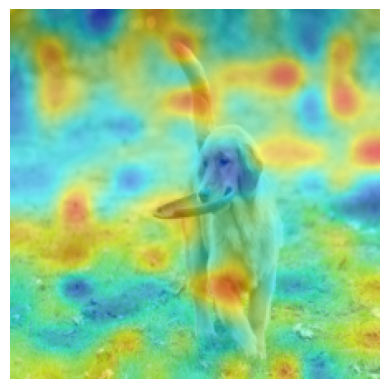

In [59]:
n_samples = 100

mask_model = MHMaskSampModel(pred_model, num_classes=1000)

x = inputs['pixel_values']
x.to(device)

with torch.no_grad():
    mask = mask_model.attribute_img(x, n_samples=n_samples)
    mask = mask.to(device)
    mask = mask.reshape(-1, 1, 14,14)
    # masked_pixels = F.interpolate(mask, inputs['pixel_values'].shape[-2:], mode='nearest')
    # x = inputs['pixel_values'].expand(n_samples, -1, -1, -1)
    # x_masked = x * (1 - masked_pixels)

    # outputs = pred_model(pixel_values=x_masked)

img = inputs['pixel_values'].squeeze(0).detach().cpu().numpy().transpose(1,2,0)

heatmap = mask[0,0].cpu().detach().numpy()

from utils.img_utils import plot_overlap_np
img_int, heatmap_img = plot_overlap_np(img, heatmap, mean, std)

In [58]:
heatmap

array([[289.81805, 294.946  , 302.4275 , 287.5869 , 254.69868, 273.19812,
        289.98883, 286.41193, 278.41052, 276.31503, 278.75912, 295.18103,
        283.74127, 272.40994],
       [290.29758, 262.93784, 290.0384 , 252.50394, 297.85556, 320.79706,
        298.91684, 275.19308, 274.84833, 290.94705, 273.95242, 270.67456,
        264.18332, 301.9702 ],
       [303.31445, 287.51166, 285.6599 , 290.30646, 262.71298, 245.2893 ,
        289.90942, 266.46872, 287.023  , 300.1873 , 298.71265, 306.6952 ,
        266.51453, 281.03918],
       [254.149  , 269.026  , 271.20572, 275.40674, 267.24402, 260.34253,
        299.85852, 309.00262, 261.9273 , 287.55756, 307.85776, 268.3046 ,
        266.89902, 255.45236],
       [247.7008 , 280.00446, 266.56906, 301.1951 , 292.7666 , 288.283  ,
        247.59523, 283.14282, 238.47134, 261.6181 , 292.62573, 285.6286 ,
        302.85413, 284.70688],
       [278.32654, 305.21838, 292.2545 , 277.97327, 291.64044, 327.45502,
        285.20404, 258.48193, 2

In [30]:
heatmap.shape

(14, 14)

In [88]:
from utils import idx_to_selector
predicted_class_idx_expanded = (torch.ones(n_samples) * predicted_class_idx).long().to(device)
probs = torch.softmax(outputs.logits, dim=-1)
selector = idx_to_selector(predicted_class_idx_expanded, 1000)

probs = (probs * selector) * (outputs.logits.argmax(-1) == predicted_class_idx).unsqueeze(-1)
probs = probs.sum(-1)

In [90]:
(outputs.logits.argmax(-1) == predicted_class_idx).sum().item()

140

In [95]:
weighted_mask = (probs.reshape(-1, 1, 1, 1) * (1 - mask)).sum(0).squeeze(0).cpu().detach().numpy()

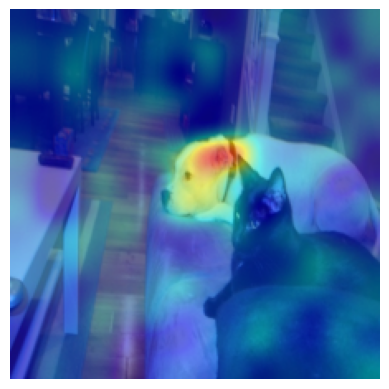

In [96]:
from utils.img_utils import plot_overlap_np, unnormalize
img = x[0].cpu().detach().numpy().transpose(1,2,0)
heatmap = weighted_mask
_, _ = plot_overlap_np(img, heatmap, mean, std)

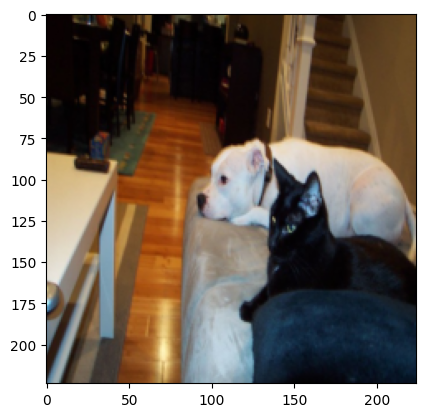

In [65]:
plt.imshow(unnormalize(img, mean, std))

In [53]:
heatmap

array([[25.053082, 25.065544, 25.09193 , 24.77479 , 26.87725 , 25.567616,
        27.329311, 21.306715, 26.781517, 27.755291, 25.301872, 26.961819,
        25.65448 , 27.368584],
       [25.377794, 27.395721, 27.674458, 25.323864, 28.144836, 26.717583,
        27.973572, 25.73487 , 24.175997, 26.679337, 24.354412, 25.263435,
        26.890526, 25.331352],
       [22.633854, 27.242489, 24.274628, 25.151842, 27.80909 , 27.962505,
        25.984325, 24.428612, 27.774654, 25.410854, 26.780409, 26.317513,
        26.480787, 27.924086],
       [24.937927, 23.815458, 23.098957, 27.038624, 26.248022, 24.395845,
        23.120453, 25.824358, 26.203547, 26.990843, 25.237682, 25.574339,
        27.724495, 26.090895],
       [26.286224, 28.362297, 27.1221  , 26.760708, 26.142372, 26.559069,
        21.124203, 24.799122, 24.543537, 27.75628 , 26.194399, 23.346054,
        25.39319 , 26.538786],
       [28.637663, 27.853954, 25.51294 , 23.865398, 22.958435, 29.6211  ,
        36.986004, 39.38366 , 3